In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import re

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
nltk.download('punkt')
nltk.download('stopwords')

seed = 42

train_df = pd.read_csv('./dataset/train_preprocess.csv', encoding='latin-1')
test_df = pd.read_csv('./dataset/test_preprocess.csv', encoding='latin-1')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_df['average_salary'] = (train_df['salary_min'] + train_df['salary_max']) / 2
train_df['salary_ratio'] = train_df['salary_max'] / train_df['salary_min']
train_df['salary_range'] = pd.cut(train_df['salary_ratio'],
                            bins=[-float('inf'), 1.25, 1.5, float('inf')],
                            labels=['Low', 'Medium', 'High'],
                            right=False) # Ensure that the intervals are left-closed
print('Training Data:')
print(train_df['salary_range'].value_counts())


test_df['average_salary'] = (test_df['salary_min'] + test_df['salary_max']) / 2
test_df['salary_ratio'] = test_df['salary_max'] / test_df['salary_min']
test_df['salary_range'] = pd.cut(test_df['salary_ratio'],
                            bins=[-float('inf'), 1.25, 1.5, float('inf')],
                            labels=['Low', 'Medium', 'High'],
                            right=False) # Ensure that the intervals are left-closed
print('Testing Data:')
print(test_df['salary_range'].value_counts())

Training Data:
salary_range
Medium    4818
High      3114
Low       2710
Name: count, dtype: int64
Testing Data:
salary_range
Medium    513
High      366
Low       303
Name: count, dtype: int64


### Text Preprocessing

In [3]:
# For training data
train_df['snippet Total Words'] = train_df['snippet'].apply(lambda x: len(x.split()))
train_df['snippet Total Chars'] = train_df['snippet'].apply(lambda x: sum(len(word) for word in x.split()))
train_df['Original snippet'] = train_df['snippet']  # Save a copy of the original text for comparison

train_df['title Total Words'] = train_df['title'].apply(lambda x: len(x.split()))
train_df['title Total Chars'] = train_df['title'].apply(lambda x: sum(len(word) for word in x.split()))
train_df['Original title'] = train_df['title']  # Save a copy of the original text for comparison

# For testing data
test_df['snippet Total Words'] = test_df['snippet'].apply(lambda x: len(x.split()))
test_df['snippet Total Chars'] = test_df['snippet'].apply(lambda x: sum(len(word) for word in x.split()))
test_df['Original snippet'] = test_df['snippet']  # Save a copy of the original text for comparison

test_df['title Total Words'] = test_df['title'].apply(lambda x: len(x.split()))
test_df['title Total Chars'] = test_df['title'].apply(lambda x: sum(len(word) for word in x.split()))
test_df['Original title'] = test_df['title']  # Save a copy of the original text for comparison

In [4]:
train_df['snippet'] = train_df['Original snippet']
train_df['title'] = train_df['Original title']

test_df['snippet'] = test_df['Original snippet']
test_df['title'] = test_df['Original title']

# Initialize removal counters
removal_counters = {
    'Removing URLs': {'characters': 0, 'words': 0},
    'Removing Punctuations': {'characters': 0, 'words': 0},
    'Removing Stopwords': {'characters': 0, 'words': 0},
    'Removing Numbers': {'characters': 0, 'words': 0},
    'Removing ASCII that cannot translate': {'characters': 0, 'words': 0},
    'Removing unnecessary whitespace': {'characters': 0, 'words': 0},
    'Stemming': {'characters': 0, 'words': 0}
}

# Function to track removed characters and words
def track_changes(original_text, processed_text, step_name):
    removed_chars = len(original_text) - len(processed_text)
    removed_words = len(original_text.split()) - len(processed_text.split())
    removal_counters[step_name]['characters'] += removed_chars
    removal_counters[step_name]['words'] += removed_words
    return processed_text


# Removing URLs
def remove_url(text):
    re_url = re.compile(r'(http\S+|www\.\S+)')
    processed_text = re_url.sub('', text)
    return track_changes(text, processed_text, 'Removing URLs')


# Removing Punctuations
exclude = string.punctuation

def remove_punc(text):
    # Combine words that should stay together
    combined_text = re.sub(r'\b(?:not|should stay together|inner-city|political-correct)\b', lambda match: match.group().replace(' ', '_'), text)
    # Remove punctuations excluding numbers and ASCII characters that did not translate
    processed_text = re.sub(r'[^\w\s]|_', '', combined_text)
    return track_changes(text, processed_text, 'Removing Punctuations')


# Removing Stopwords
def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = set(stopwords.words('english'))
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    processed_text = ' '.join(new_list)
    return track_changes(text, processed_text, 'Removing Stopwords')


# Removing Numbers
def remove_numbers(text):
    processed_text = re.sub(r'\b\d+\b', '', text)
    return track_changes(text, processed_text, 'Removing Numbers')


# Removing ASCII characters that cannot translate
def remove_non_translatable_ascii(text):
    processed_text = ''.join(char for char in text if char.isascii() and not char.isdigit())
    return track_changes(text, processed_text, 'Removing ASCII that cannot translate')


# Removing unnecessary whitespace
def remove_unnecessary_whitespace(text):
    processed_text = ' '.join(text.split())
    return track_changes(text, processed_text, 'Removing unnecessary whitespace')


# Stemming
def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = [stemmer.stem(word) for word in word_tokenize(text)]
    processed_text = " ".join(new_list)
    return track_changes(text, processed_text, 'Stemming')

In [5]:
# Handle Training Data
train_df['snippet'] = train_df['snippet'].apply(lambda x: x.lower())
train_df['snippet'] = train_df['snippet'].apply(remove_url)
train_df['snippet'] = train_df['snippet'].apply(remove_punc)
train_df['snippet'] = train_df['snippet'].apply(remove_stopwords)
train_df['snippet'] = train_df['snippet'].apply(remove_numbers)
train_df['snippet'] = train_df['snippet'].apply(remove_non_translatable_ascii)
train_df['snippet'] = train_df['snippet'].apply(remove_unnecessary_whitespace)
train_df['snippet'] = train_df['snippet'].apply(perform_stemming)

# Creating new column 'Total Words After Transformation'
train_df['Total Words of snippet After Transformation'] = train_df['snippet'].apply(lambda x: len(x.split()))
train_df['Total Chars of snippet After Transformation'] = train_df['snippet'].apply(lambda x: sum(len(word) for word in x.split()))

# Display the removal counters in table format
removal_counters_train_df = pd.DataFrame(removal_counters).T
print('Training Data:')
print("Snippet Removal Counters:")
print(removal_counters_train_df)
# print(train_df[['snippet', 'Original snippet']])

# reinitialize removal counters
removal_counters = {
    'Removing URLs': {'characters': 0, 'words': 0},
    'Removing Punctuations': {'characters': 0, 'words': 0},
    'Removing Stopwords': {'characters': 0, 'words': 0},
    'Removing Numbers': {'characters': 0, 'words': 0},
    'Removing ASCII that cannot translate': {'characters': 0, 'words': 0},
    'Removing unnecessary whitespace': {'characters': 0, 'words': 0},
    'Stemming': {'characters': 0, 'words': 0}
}

train_df['title'] = train_df['title'].apply(lambda x: x.lower())
train_df['title'] = train_df['title'].apply(remove_url)
train_df['title'] = train_df['title'].apply(remove_punc)
train_df['title'] = train_df['title'].apply(remove_stopwords)
train_df['title'] = train_df['title'].apply(remove_numbers)
train_df['title'] = train_df['title'].apply(remove_non_translatable_ascii)
train_df['title'] = train_df['title'].apply(remove_unnecessary_whitespace)
train_df['title'] = train_df['title'].apply(perform_stemming)

# Creating new column 'Total Words After Transformation'
train_df['Total Words of title After Transformation'] = train_df['title'].apply(lambda x: len(x.split()))
train_df['Total Chars of title After Transformation'] = train_df['title'].apply(lambda x: sum(len(word) for word in x.split()))

# Display the removal counters in table format
removal_counters_train_df = pd.DataFrame(removal_counters).T
print("Title Removal Counters:")
print(removal_counters_train_df)
# print(df[['title', 'Original title']])

Training Data:
Snippet Removal Counters:
                                      characters  words
Removing URLs                                533      2
Removing Punctuations                      44906    944
Removing Stopwords                        269506  69580
Removing Numbers                            4620   3219
Removing ASCII that cannot translate        1112      0
Removing unnecessary whitespace             3219      0
Stemming                                  245509      0
Title Removal Counters:
                                      characters  words
Removing URLs                                  0      0
Removing Punctuations                       9608   2325
Removing Stopwords                          5178    789
Removing Numbers                             546    267
Removing ASCII that cannot translate         657      0
Removing unnecessary whitespace              267      0
Stemming                                   52649      0


In [6]:
# Handle Testing Data
test_df['snippet'] = test_df['snippet'].apply(lambda x: x.lower())
test_df['snippet'] = test_df['snippet'].apply(remove_url)
test_df['snippet'] = test_df['snippet'].apply(remove_punc)
test_df['snippet'] = test_df['snippet'].apply(remove_stopwords)
test_df['snippet'] = test_df['snippet'].apply(remove_numbers)
test_df['snippet'] = test_df['snippet'].apply(remove_non_translatable_ascii)
test_df['snippet'] = test_df['snippet'].apply(remove_unnecessary_whitespace)
test_df['snippet'] = test_df['snippet'].apply(perform_stemming)

# Creating new column 'Total Words After Transformation'
test_df['Total Words of snippet After Transformation'] = test_df['snippet'].apply(lambda x: len(x.split()))
test_df['Total Chars of snippet After Transformation'] = test_df['snippet'].apply(lambda x: sum(len(word) for word in x.split()))

# Display the removal counters in table format
removal_counters_test_df = pd.DataFrame(removal_counters).T
print('Testing Data:')
print("Snippet Removal Counters:")
print(removal_counters_test_df)
# print(test_df[['snippet', 'Original snippet']])

# reinitialize removal counters
removal_counters = {
    'Removing URLs': {'characters': 0, 'words': 0},
    'Removing Punctuations': {'characters': 0, 'words': 0},
    'Removing Stopwords': {'characters': 0, 'words': 0},
    'Removing Numbers': {'characters': 0, 'words': 0},
    'Removing ASCII that cannot translate': {'characters': 0, 'words': 0},
    'Removing unnecessary whitespace': {'characters': 0, 'words': 0},
    'Stemming': {'characters': 0, 'words': 0}
}

test_df['title'] = test_df['title'].apply(lambda x: x.lower())
test_df['title'] = test_df['title'].apply(remove_url)
test_df['title'] = test_df['title'].apply(remove_punc)
test_df['title'] = test_df['title'].apply(remove_stopwords)
test_df['title'] = test_df['title'].apply(remove_numbers)
test_df['title'] = test_df['title'].apply(remove_non_translatable_ascii)
test_df['title'] = test_df['title'].apply(remove_unnecessary_whitespace)
test_df['title'] = test_df['title'].apply(perform_stemming)

# Creating new column 'Total Words After Transformation'
test_df['Total Words of title After Transformation'] = test_df['title'].apply(lambda x: len(x.split()))
test_df['Total Chars of title After Transformation'] = test_df['title'].apply(lambda x: sum(len(word) for word in x.split()))

# Display the removal counters in table format
removal_counters_test_df = pd.DataFrame(removal_counters).T
print("Title Removal Counters:")
print(removal_counters_test_df)

Testing Data:
Snippet Removal Counters:
                                      characters  words
Removing URLs                                 42      0
Removing Punctuations                      14584   2440
Removing Stopwords                         35137   8524
Removing Numbers                            1007    603
Removing ASCII that cannot translate         807      1
Removing unnecessary whitespace              604      0
Stemming                                   79724      0
Title Removal Counters:
                                      characters  words
Removing URLs                                  0      0
Removing Punctuations                       1102    250
Removing Stopwords                           672    115
Removing Numbers                              70     31
Removing ASCII that cannot translate          88      0
Removing unnecessary whitespace               31      0
Stemming                                    5990      0


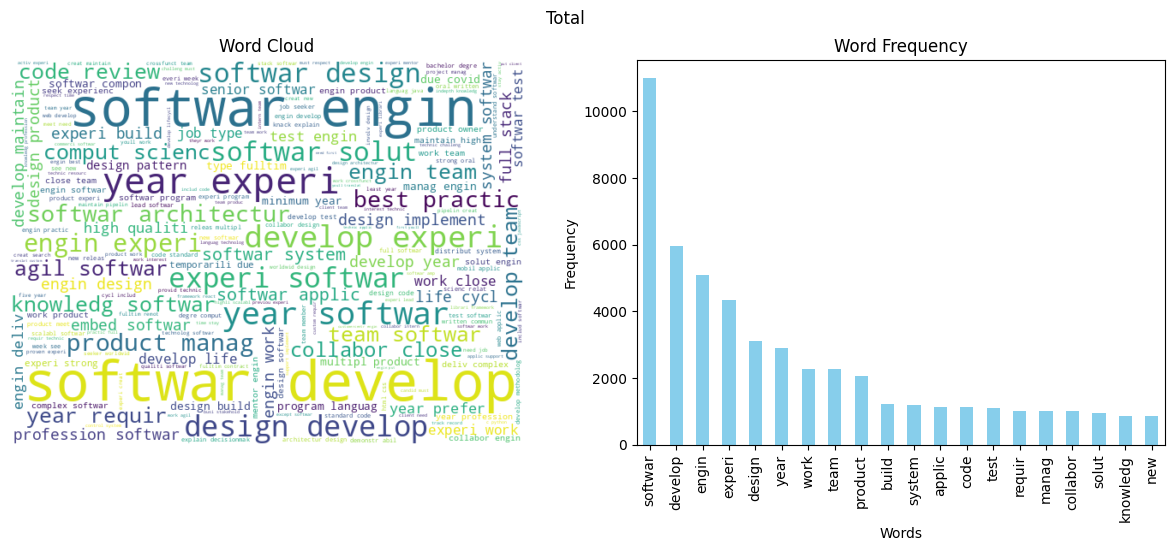

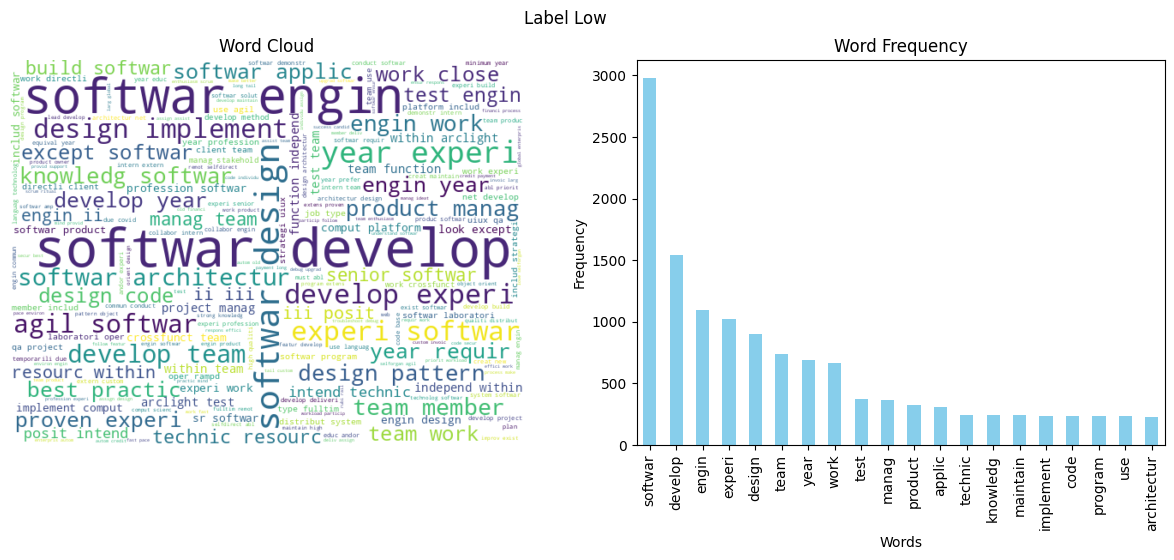

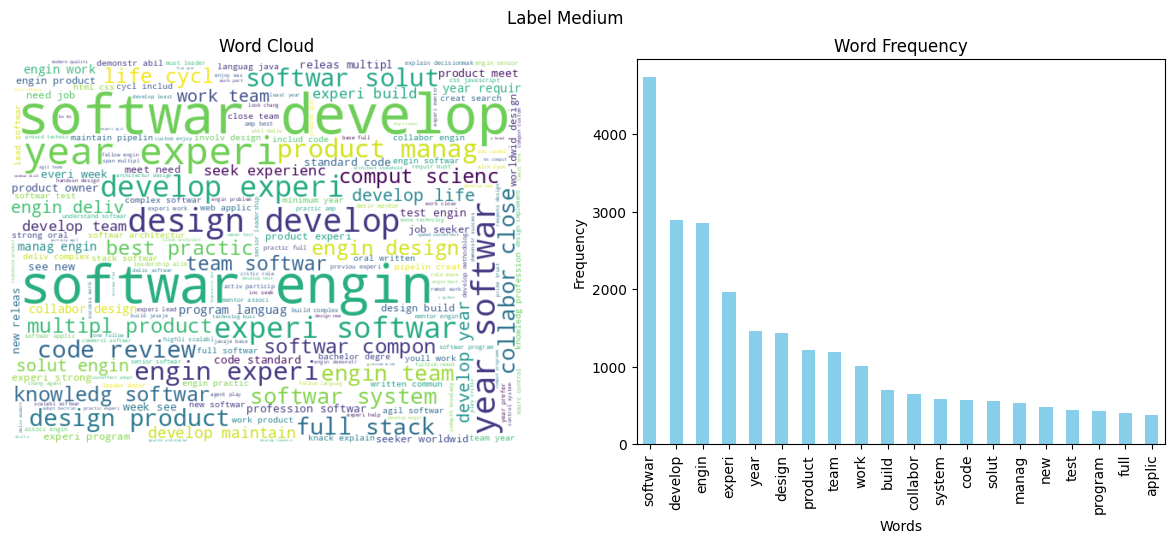

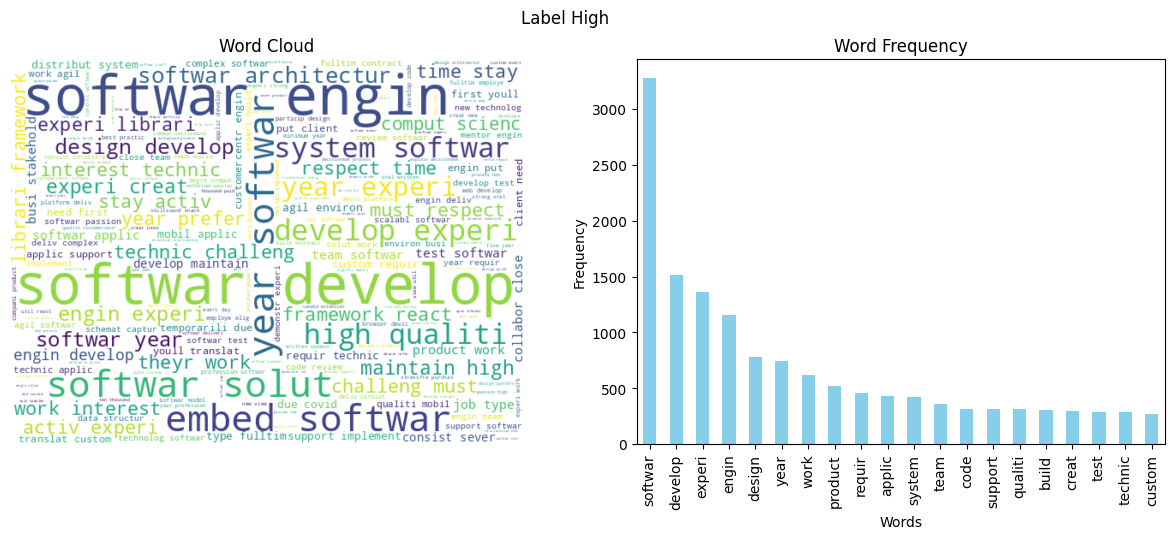

In [7]:
# Word Cloud and Word Frequency in 1 Figure
def generate_combined_plot(data, title):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Generate Word Cloud
    wordcloud = WordCloud(width=600, height=450, max_words=200, background_color='white').generate(data)
    axes[0].imshow(wordcloud, interpolation='bilinear')
    axes[0].axis('off')
    axes[0].set_title('Word Cloud')

    # Generate Word Frequency Bar Plot
    word_freq = pd.Series(' '.join(re.findall(r'\b\w+\b', data)).split()).value_counts().sort_values(ascending=False)[:20]
    word_freq.plot(kind='bar', color='skyblue', ax=axes[1])
    axes[1].set_title('Word Frequency')
    axes[1].set_xlabel('Words')
    axes[1].set_ylabel('Frequency')

    plt.suptitle(title)
    plt.show()

# Generate combined plot for the total dataset
generate_combined_plot(' '.join(train_df['snippet']), 'Total')

# Generate combined plot for label 0
generate_combined_plot(' '.join(train_df[train_df['salary_range'] == 'Low']['snippet']), 'Label Low')

# Generate combined plot for label 1
generate_combined_plot(' '.join(train_df[train_df['salary_range'] == 'Medium']['snippet']), 'Label Medium')

# Generate combined plot for label 1
generate_combined_plot(' '.join(train_df[train_df['salary_range'] == 'High']['snippet']), 'Label High')

### Text Classification

In [8]:
def model_evaluate(model, X, y_true, title):
    # Make predictions
    y_pred = model.predict(X)
    
    # Evaluate the model by accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Display classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    # Display confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):  # Assuming you have 3 classes
        fpr[i], tpr[i], _ = roc_curve(label_binarize(y_true, classes=[0, 1, 2])[:, i], model.decision_function(X)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr_micro, tpr_micro, _ = roc_curve(label_binarize(y_true, classes=[0, 1, 2]).ravel(), model.decision_function(X).ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    # Compute macro-average ROC curve and ROC area
    fpr_macro = np.linspace(0, 1, 100)
    tpr_macro = np.zeros_like(fpr_macro)
    for i in range(3):  # Assuming you have 3 classes
        tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
    tpr_macro /= 3
    roc_auc_macro = auc(fpr_macro, tpr_macro)

    # Plot ROC curves
    plt.figure(figsize=(8, 6))

    # Plot micro-average ROC curve
    plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
    # print(f"SVM Val Micro Average AUC = {roc_auc_micro:.2f}")

    # Plot macro-average ROC curve
    plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
    # print(f"SVM Val Macro Average AUC = {roc_auc_macro:.2f}")

    # Plot individual class ROC curves
    for i in range(3):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
        # print(f"SVM Val Class {i} AUC = {roc_auc[i]:.2f}")

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

SVM Cross-Validation Scores: [0.86435702 0.85202584 0.86905461 0.86897767 0.85370153]
SVM Cross-Validated Accuracy: 0.86 +/- 0.01
Accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       964
           1       0.86      0.83      0.84       623
           2       0.82      0.82      0.82       542

    accuracy                           0.86      2129
   macro avg       0.86      0.85      0.86      2129
weighted avg       0.86      0.86      0.86      2129

Confusion Matrix:
[[879  40  45]
 [ 51 517  55]
 [ 53  44 445]]


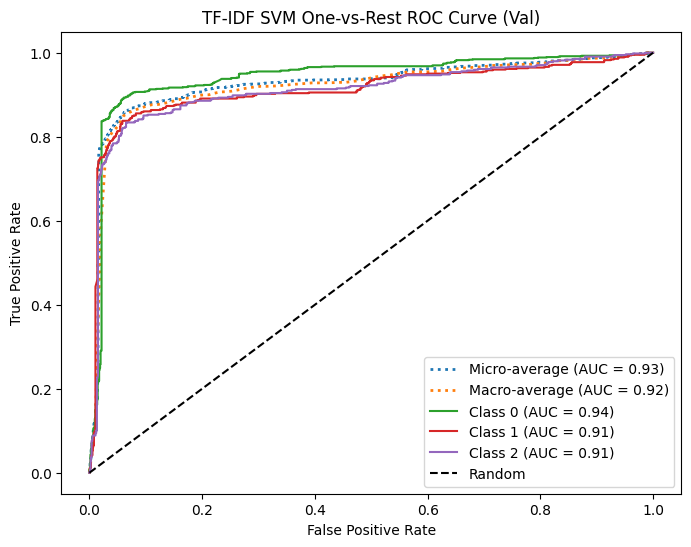

Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       513
           1       0.89      0.84      0.86       366
           2       0.82      0.83      0.82       303

    accuracy                           0.87      1182
   macro avg       0.86      0.86      0.86      1182
weighted avg       0.87      0.87      0.87      1182

Confusion Matrix:
[[466  23  24]
 [ 26 309  31]
 [ 36  17 250]]


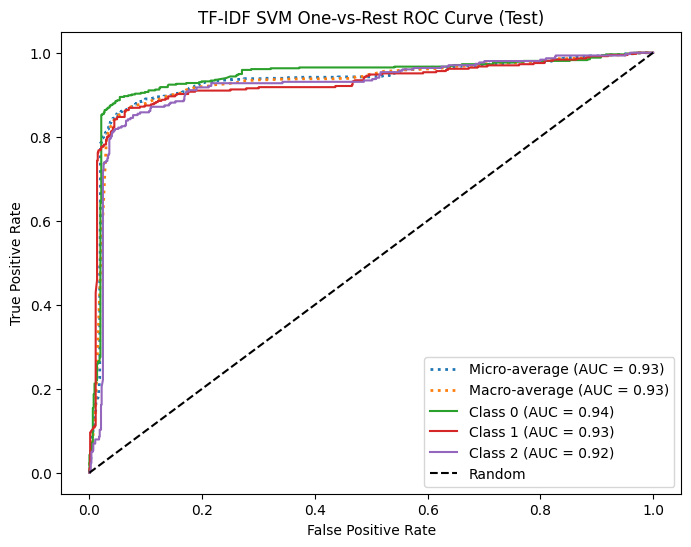

In [9]:
# split the training set into train and validation
X = train_df['snippet']
y = train_df['salary_range']
y = y.map({'Medium': 0, 'High': 1, 'Low': 2})
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# SVM Classifier
svm_classifier = SVC(kernel='linear', C=1)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('classifier', svm_classifier)])

# Use cross-validation for better accuracy estimation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Fit the model using cross-validation on the training set
cv_scores = cross_val_score(clf, X_train_tfidf, y_train, cv=cv, scoring='accuracy')

# Print the cross-validated accuracy
print("SVM Cross-Validation Scores:", cv_scores)
print(f"SVM Cross-Validated Accuracy: {cv_scores.mean():.2f} +/- {cv_scores.std():.2f}")

# Fit the model on the entire training set
svm_classifier.fit(X_train_tfidf, y_train)
model_evaluate(svm_classifier, X_val_tfidf, y_val, "TF-IDF SVM One-vs-Rest ROC Curve (Val)")


# Testing
X_test = test_df['snippet']
y_test = test_df['salary_range']
y_test = y_test.map({'Medium': 0, 'High': 1, 'Low': 2})
X_test_tfidf = vectorizer.transform(X_test)
model_evaluate(svm_classifier, X_test_tfidf, y_test, "TF-IDF SVM One-vs-Rest ROC Curve (Test)")